In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seabroad as broad
import seaborn as sns
import time
import ipywidgets as widgets
from ipywidgets import interact

sns.set_style("white")
sns.set_context("talk")

%matplotlib inline

In [2]:
query = ("https://data.seattle.gov/resource/v9zk-3thk.json")
raw_data = pd.read_json(query)
raw_data.head(1)

,actual_download,actual_upload,advertised_download,advertised_upload,connection_type,cost_of_service,date_pretty,id,isp,isp_user,min_rtt,seattle_blkgrpce10,timestamp
0,81.88,5.86,NaN,NaN,wired,100_or_above,"Mon, 07 Mar 2016 17:45:07 GMT",1657,comcast,comcast,4,NaN,2016-03-07 17:45:07


In [3]:
raw_data.count()

actual_download        2684
actual_upload          2685
advertised_download    1085
advertised_upload      1018
connection_type        2685
cost_of_service        2685
date_pretty            2685
id                     2685
isp                    2667
isp_user               2590
min_rtt                2685
seattle_blkgrpce10     1064
timestamp              2685
dtype: int64

## Data cleaning and Recoding

Calculate ratios of actual speeds to advertised speeds

In [4]:
def speed_ratios(df):
    df['dl_ratio'] = df['actual_download'] / df['advertised_download'] * 100
    df['ul_ratio'] = df['actual_upload'] / df['advertised_upload'] * 100
    df['dl_ratio'].replace([np.inf, -np.inf], np.nan)
    df['ul_ratio'].replace([np.inf, -np.inf], np.nan)
    
    return df

Convert cost of service to useful numeric format

In [5]:
def clean_cost(df):
    costs = df.cost_of_service
    costs = costs.str.replace('_', ' ')
    #costs = costs.str.replace('dont_know','-1')
    cost_int = []
    for cost in costs:
        nums = [int(s) for s in cost.split() if s.isdigit()]

        if (len(nums)) == 0:
            nums = float('NaN')
        elif (len(nums) == 1) & (nums[0] == 25):
            nums[0] = 0
            nums = nums[0]
        elif (len(nums) == 1) & (nums[0] == 100):
            nums[0] = 100
            nums = nums[0]
        else:
            nums = nums[0]

        cost_int.append(nums)

    df['cost_int'] = cost_int
    df['cost_mean'] = df['cost_int'] + 12.5
    
    return df

Calculate costs: Mb per \$ and \$ per Mb.

In [6]:
def calculate_costs(df):

    df['dl_per_dollar'] = df.actual_download / df.cost_mean
    df['ul_per_dollar'] = df.actual_upload / df.cost_mean
    df['dl_per_dollar'].replace([np.inf, -np.inf], np.nan)
    df['ul_per_dollar'].replace([np.inf, -np.inf], np.nan)
    
    df['dollar_per_dl'] = df.cost_mean / df.actual_download
    df['dollar_per_ul'] = df.cost_mean / df.actual_upload
    df['dollar_per_ul'].replace([np.inf, -np.inf], np.nan)
    df['dollar_per_dl'].replace([np.inf, -np.inf], np.nan)
    
    return df

Combine wireless-single and wireless_multiple

In [7]:
def wireless_combine(df):

    connection_types = df.connection_type

    wired_wireless = []
    for connection in connection_types:
        if (connection == 'wireless-multiple') | (connection == 'wireless-single'):
            w = 'Wireless'
        elif (connection == 'wired'):
            w = 'Wired'

        wired_wireless.append(w)

    df['wired_wireless'] = wired_wireless
    
    return df

Parse dates and times

In [8]:
def parse_date_time(df):

    date_pretty = df.date_pretty
    date_objs = [time.strptime(date, '%a, %d %b %Y %H:%M:%S %Z') for date in date_pretty]
    df['date'] = date_objs
    
    hour = [time.strftime('%H', date_obj) for date_obj in date_objs]
    hour = [int(x) for x in hour]
    df['hour'] = hour

    day = [time.strftime('%a', date_obj) for date_obj in date_objs]
    df['day'] = day

    day_nums = [obj[6] for obj in date_objs]
    df['day_num'] = day_nums

    months = [time.strftime('%m', date_obj) for date_obj in date_objs]
    df['month'] = months

    month_nums = [obj[1] for obj in date_objs]
    df['month_num'] = month_nums

    years = [time.strftime('%Y', date_obj) for date_obj in date_objs]
    df['year'] = years

    year_days = [obj[7] for obj in date_objs]
    df['year_day'] = year_days

    wkdays = df.day_num < 5
    df['wkday'] = wkdays
    
    return df

Swap possibly incorrectly labelled advertised speeds.

In [9]:
def swap_advertised(df):

    df['ad_swapped'] = df['advertised_download'] < df['advertised_upload']
    
    s_dl_ad = df['advertised_download']
    s_ul_ad = df['advertised_upload']

    s_dl_ad_swapped = []
    s_ul_ad_swapped = []

    for i in xrange(0, len(s_dl_ad)):
        dl = s_dl_ad[i]
        ul = s_ul_ad[i]

        if ul > dl:
            s_dl_ad_swapped.append(ul)
            s_ul_ad_swapped.append(dl)
        elif (ul < dl):
            s_dl_ad_swapped.append(dl)
            s_ul_ad_swapped.append(ul)
        elif (np.isnan(ul)):
            s_dl_ad_swapped.append(dl)
            s_ul_ad_swapped.append(float('NaN'))
        elif (np.isnan(dl)):
            s_dl_ad_swapped.append(float('NaN'))
            s_ul_ad_swapped.append(ul)
        else:
            s_dl_ad_swapped.append(float('NaN'))
            s_ul_ad_swapped.append(float('NaN')) 

    df['dl_ad_swap'] = s_dl_ad_swapped
    df['ul_ad_swap'] = s_ul_ad_swapped
    
    df['dl_ratio_swap'] = df['actual_download'] / df['dl_ad_swap'] * 100
    df['ul_ratio_swap'] = df['actual_upload'] / df['ul_ad_swap'] * 100
    df['dl_ratio_swap'].replace([np.inf, -np.inf], np.nan)
    df['ul_ratio_swap'].replace([np.inf, -np.inf], np.nan)
    
    return df

In [11]:
def clean_data(df):
    
    df = df.copy()
    
    df = clean_cost(df)
    
    df = speed_ratios(df)
    
    df = calculate_costs(df)
    
    df = wireless_combine(df)
    
    df = parse_date_time(df)
    
    df = swap_advertised(df)
    
    return df

df = clean_data(raw_data)

df.head()

,actual_download,actual_upload,advertised_download,advertised_upload,connection_type,cost_of_service,date_pretty,id,isp,isp_user,...,month,month_num,year,year_day,wkday,ad_swapped,dl_ad_swap,ul_ad_swap,dl_ratio_swap,ul_ratio_swap
0,81.88,5.86,NaN,NaN,wired,100_or_above,"Mon, 07 Mar 2016 17:45:07 GMT",1657,comcast,comcast,...,03,3,2016,67,True,False,NaN,NaN,NaN,NaN
1,0.20,5.75,75.0,7.0,wired,100_or_above,"Fri, 19 Feb 2016 18:00:47 GMT",1455,comcast,comcast,...,02,2,2016,50,True,False,75.0,7.0,0.266667,82.142857
2,7.97,3.72,NaN,NaN,wireless-multiple,50_75,"Thu, 11 Feb 2016 17:31:37 GMT",182,centurylink,centurylink,...,02,2,2016,42,True,False,NaN,NaN,NaN,NaN
3,13.11,1.21,17.0,1.0,wired,less_than_25,"Thu, 21 Jul 2016 19:40:54 GMT",2344,twc,Time Warner Cable,...,07,7,2016,203,True,False,17.0,1.0,77.117647,121.000000
4,0.23,8.86,NaN,NaN,wireless-multiple,75_100,"Sun, 14 Feb 2016 12:58:14 GMT",893,comcast,comcast,...,02,2,2016,45,False,False,NaN,NaN,NaN,NaN


## Useful Stuff

Some percentiles

In [12]:
quintile_percentages = range(0,120,20)
quartile_percentages = range(0,125,25)

Minimum and maximum download and upload values.

In [13]:
dlmin, dlmax = broad.minmax(df, 'actual_download')
ulmin, ulmax = broad.minmax(df, 'actual_upload')

print dlmin, dlmax
print ulmin, ulmax

0.0 884.43
0.0 881.48


## Download and Upload Speeds

### Distribution of DL Speeds

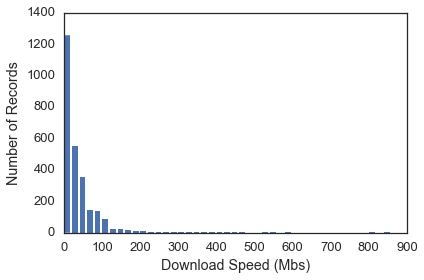

In [64]:
dl_binsize = 20
dl_bins = np.arange(dlmin, dlmax+dl_binsize, dl_binsize)


fig = plt.figure()
ax = fig.add_subplot(111)
ax = df_dl.hist(bins=dl_bins, grid=False, edgecolor=None, width=15, range=[0, dlmax+dl_binsize], linewidth=0)
ax.set_xlabel("Download Speed (Mbs)")
ax.set_ylabel("Number of Records")
plt.tight_layout()

#plt.savefig('dl_hist.pdf')

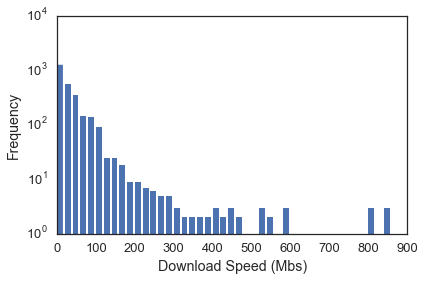

In [66]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax = df_dl.hist(bins=dl_bins, grid=False, edgecolor=None, width=15, log=True, range=[0, dlmax+dl_binsize], linewidth=0)
ax.set_xlabel("Download Speed (Mbs)")
ax.set_ylabel("Frequency")
plt.tight_layout()
#plt.savefig('dl_histlog.pdf')

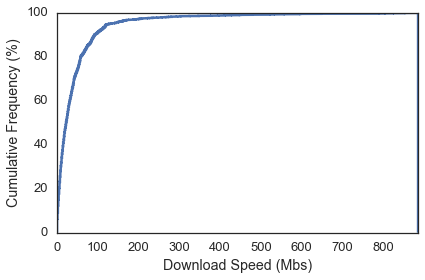

In [67]:
dl_bin_cum_size = 1
dl_bins_cum = np.arange(dlmin, dlmax + dl_bin_cum_size, dl_bin_cum_size)

fig = plt.figure()
ax = fig.add_subplot(111)
ax = df_dl.hist(bins=dl_bins_cum, grid=False, cumulative=True, histtype='step', normed=True, linewidth=2.5)
ax.set_xlabel("Download Speed (Mbs)")
ax.set_ylabel("Cumulative Frequency (%)")
ax.set_xlim(0,dlmax)
ax.set_yticklabels(quintile_percentages)
plt.tight_layout()
#plt.savefig('dl_cdf.pdf')

In [79]:
s = df['actual_download'].dropna()
print s.quantile(.50)

s = df['actual_download'].dropna()
print s.quantile(.75)

s = df['actual_download'].dropna()
print s.quantile(.98)

22.65
52.0875
261.553


The distribution of download speeds appears to be exponential or Pareto in shape. Around 75% of results appear to give download speeds of less than 50 Mbps and 50 % of results score 25 Mbps or less. Around 2 % of results seem to achieve speeds over 250 Mbps, the threshold for 'Gigabit' internet services.

### Distribution of UL Speeds

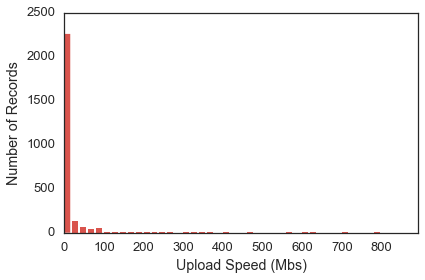

In [72]:
df_ul = df.actual_upload
ulmin, ulmax = broad.minmax(df, col='actual_upload')

ul_bins = np.arange(ulmin, ulmax+10, 20)

fig = plt.figure()
ax = fig.add_subplot(111)
ax = df_ul.hist(bins=ul_bins, grid=False, edgecolor=None, width=15, linewidth=0, color=sns.xkcd_rgb["pale red"])
ax.set_xlabel("Upload Speed (Mbs)")
ax.set_ylabel("Number of Records")
ax.set_xlim(0,ulmax+10)
plt.tight_layout()
#plt.savefig('graphs/ul_hist.pdf')

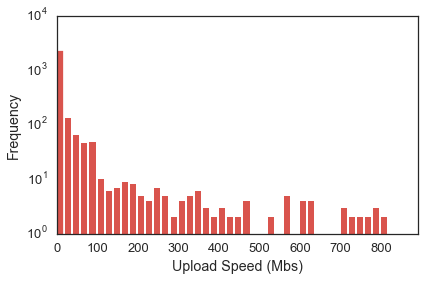

In [73]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax = df_ul.hist(bins=ul_bins, grid=False, edgecolor=None, width=15, log=True, linewidth=0, color=sns.xkcd_rgb["pale red"])
ax.set_xlabel("Upload Speed (Mbs)")
ax.set_ylabel("Frequency")
ax.set_xlim(0,ulmax+10)
plt.tight_layout()
#plt.savefig('ul_histlog.pdf')

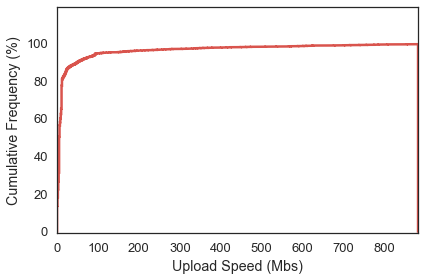

In [74]:
ul_bin_cum_size = 1
ul_bins_cum = np.arange(ulmin, ulmax+ul_bin_cum_size, ul_bin_cum_size)

fig = plt.figure()
ax = fig.add_subplot(111)
ax = df_ul.hist(bins=ul_bins_cum, grid=False, cumulative=True, histtype='step', normed=True, linewidth=2.5, color=sns.xkcd_rgb["pale red"])
ax.set_xlabel("Upload Speed (Mbs)")
ax.set_ylabel("Cumulative Frequency (%)")
ax.set_xlim(0, ulmax)
ax.set_yticklabels(quintile_percentages)
plt.tight_layout()
#plt.savefig('ul_cdf.pdf')

In [80]:
s = df['actual_upload'].dropna()
print s.quantile(.50)

s = df['actual_upload'].dropna()
print s.quantile(.75)

s = df['actual_upload'].dropna()
print s.quantile(.98)

5.97
11.84
356.894


Upload speeds follow a similar trend to download speeds, with an even steeper drop off rate. About 65 % of results scored download speeds of less than 10 Mbps and 90 % recording less than 50 Mbps. There are some instances of very high upload speeds.

### Does download speed predict upload speed?

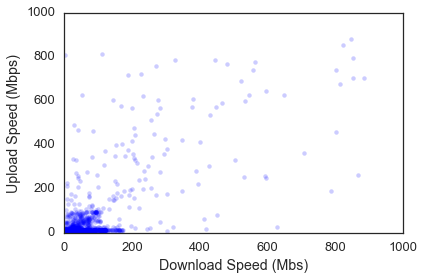

In [81]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(df_dl, df_ul, alpha=0.2, linewidth=0)
ax.set_xlabel("Download Speed (Mbs)")
ax.set_ylabel("Upload Speed (Mbps)")
ax.set_ylim(0,1000)
ax.set_xlim(0,1000)
plt.tight_layout()
#plt.savefig('dl_vs_ul.pdf')

Download and upload speeds to not appear to be strongly correlated at a first glance, with the vast majority of both concentrated at low values

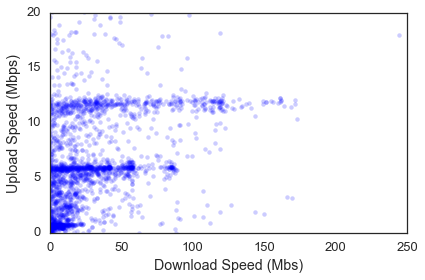

In [82]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(df_dl, df_ul, alpha=0.2, linewidth=0)
ax.set_xlabel("Download Speed (Mbs)")
ax.set_ylabel("Upload Speed (Mbps)")
ax.set_ylim(0,20)
ax.set_xlim(0,250)
plt.tight_layout()
plt.savefig('dl_vs_ul_zoom.pdf')

Focussing in on download speeds < 200 Mbps and upload speeds < 20 Mbps shows 3 clear upload speed bands at around 1, 6 and 12 Mbps. The lower the upload speed of the band, the lower the spread across download speeds.

Why is this? ISP throttle? Threshold caused by hardware? 

# ISPs

I'm mostly interested in broadband of citizens, as opposed to organisations and businesses so I will reduce the data to look at only the information concerning the 3 main ISPs in the city; Century Link, Comcast and Wave.   

In [83]:
df_isps = df[(df.isp_user == 'centurylink') | (df.isp_user == 'comcast') | (df.isp_user == 'wave')]
print "Number of records for CenturyLink, Comcast and Wave: ", len(df_isps)

Number of records for CenturyLink, Comcast and Wave:  2370


Limit to download speeds below 250 Mbps. Use actual download as advertised download is not provided for all records.

In [45]:
df_isps = df_isps[df_isps.actual_download < 250]

In [84]:
isp_groups = df_isps.groupby(['isp_user', 'wired_wireless'])
isp_groups.actual_download.count()

isp_user     wired_wireless
centurylink  Wired             264
             Wireless          417
comcast      Wired             532
             Wireless          942
wave         Wired              78
             Wireless          136
Name: actual_download, dtype: int64

Seems like Comcast has the most users, followed by CenturyLink and then Wave - roughly in line with what we would expect.

In [85]:
isp_names = ['CenturyLink', 'Comcast', 'Wave']
isp_colours = ['#00cc66', '#ff6666', '#57c6fa']

## ISP Download Speeds

In [50]:
for i, group in isp_groups:
    print i
#    print "Number of records:", len(group)
    print "Mean DL: ", group.actual_download.mean()
    print "Median DL: ", group.actual_download.median()
    print "Std DL: ", group.actual_download.std()
    print '--------------'

('centurylink', 'Wired')
Mean DL:  33.6706451613
Median DL:  15.28
Std DL:  44.0957295273
--------------
('centurylink', 'Wireless')
Mean DL:  19.142825
Median DL:  10.31
Std DL:  27.4304246734
--------------
('comcast', 'Wired')
Mean DL:  49.5516432866
Median DL:  40.92
Std DL:  41.1487400455
--------------
('comcast', 'Wireless')
Mean DL:  31.4477765363
Median DL:  20.8
Std DL:  32.2202719004
--------------
('wave', 'Wired')
Mean DL:  60.52328125
Median DL:  52.095
Std DL:  42.5529145871
--------------
('wave', 'Wireless')
Mean DL:  38.4841176471
Median DL:  33.6
Std DL:  26.9267475052
--------------


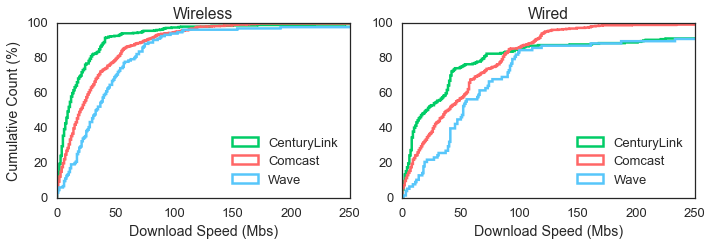

In [86]:
bincumsize = 1
bins_cum = np.arange(0, 1000+bincumsize, bincumsize)

plt.figure(figsize=(10,3.5))

ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)

count = 0
for i, group in isp_groups:
    if 'Wireless' in i:
        ax1.hist(group.actual_download, cumulative=True, bins=bins_cum, range=[0,400], histtype='step',\
                    normed=True, linewidth=2.5, label=isp_names[count], color=isp_colours[count])
        count += 1
    elif 'Wired' in i:
        ax2.hist(group.actual_download, cumulative=True, bins=bins_cum, range=[0,400], histtype='step',\
                    normed=True, linewidth=2.5, label=isp_names[count], color=isp_colours[count])
        
    


ax1.set_xlabel("Download Speed (Mbs)")
ax2.set_xlabel("Download Speed (Mbs)")
ax1.set_ylabel("Cumulative Count (%)")
ax2.set_xlim(0,250)
ax1.set_xlim(0,250)
ax2.set_ylim(0,1)
ax1.set_ylim(0,1)
ax1.set_title('Wireless')
ax2.set_title('Wired')
ax1.legend(loc='lower right')
ax2.legend(loc='lower right')
ax1.set_yticklabels(quintile_percentages)
ax2.set_yticklabels(quintile_percentages)
plt.tight_layout()
#plt.savefig('dl_cdf_contype.pdf')

At low speeds (~50 Mbps) wired and wireless connections similar distributions for all three ISPs. Around 80% of speeds measured are at 40, 50 and 60 Mbps for Centurylink, Comcast and Wave respectively. For wireless connections, essentially all speeds measured are below 100 Mbps for all ISPs, bar a few high speeds up to about 200 Mbps for Century link and Wave. For wired connections, 100% of speeds measured from Comcast measure at just over 100 Mbps or less. CenturyLink and Wave however display some uptake (about 10%) of "Gigabit" speeds. The percentage of records for Gigabit levels of speed is very small so these distributions may be subject to sampling errors.

This is not a fair comparison of speeds delivered for multiple reasons.

## ISP Upload Speeds

In [87]:
for i, group in isp_groups:
    print i
#    print "Number of records:", len(group)
    print "Mean UL: ", group.actual_upload.mean()
    print "Median UL: ", group.actual_upload.median()
    print "Std UL: ", group.actual_upload.std()
    print '--------------'

(u'centurylink', 'Wired')
Mean UL:  69.0789772727
Median UL:  4.305
Std UL:  169.30288405
--------------
(u'centurylink', 'Wireless')
Mean UL:  15.5361630695
Median UL:  3.77
Std UL:  46.5409989661
--------------
(u'comcast', 'Wired')
Mean UL:  12.4054596623
Median UL:  6.39
Std UL:  37.6433660995
--------------
(u'comcast', 'Wireless')
Mean UL:  9.71850318471
Median UL:  6.01
Std UL:  27.2625051845
--------------
(u'wave', 'Wired')
Mean UL:  115.461538462
Median UL:  14.115
Std UL:  219.43209373
--------------
(u'wave', 'Wireless')
Mean UL:  40.0194852941
Median UL:  6.71
Std UL:  74.0483964797
--------------


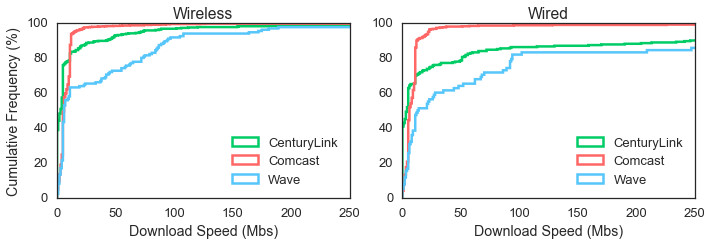

In [88]:
bincumsize = 1
bins_cum = np.arange(0, 1000+bincumsize, bincumsize)

plt.figure(figsize=(10,3.5))

ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)

count = 0
for i, group in isp_groups:
    if 'Wireless' in i:
        ax1.hist(group.actual_upload, cumulative=True, bins=bins_cum, range=[0,400], histtype='step',\
                    normed=True, linewidth=2.5, label=isp_names[count], color=isp_colours[count])
        count += 1
    elif 'Wired' in i:
        ax2.hist(group.actual_upload, cumulative=True, bins=bins_cum, range=[0,400], histtype='step',\
                    normed=True, linewidth=2.5, label=isp_names[count], color=isp_colours[count])
        
    


ax1.set_xlabel("Download Speed (Mbs)")
ax2.set_xlabel("Download Speed (Mbs)")
ax1.set_ylabel("Cumulative Frequency (%)")
ax2.set_xlim(0,250)
ax1.set_xlim(0,250)
ax2.set_ylim(0,1)
ax1.set_ylim(0,1)
ax1.set_title('Wireless')
ax2.set_title('Wired')
ax1.legend(loc='lower right')
ax2.legend(loc='lower right')
ax1.set_yticklabels(quintile_percentages)
ax2.set_yticklabels(quintile_percentages)
plt.tight_layout()
#plt.savefig('ul_cdf_contype.pdf')

Wave also seems to have the a larger distribution for higher upload speeds, followed by CenturyLink. Around 50% of CenturyLink and 70% of Wave records are 10 Mbps and under. Comcast tails off very quickly, with virtually no upload speeds much more than 50 Mbps.

Again this is not a fair comparison between ISPs.

## DL vs UL for ISPs

Group by ISP and ignore differences in connection type.

In [90]:
isp_groups_allcon = df_isps.groupby('isp_user')

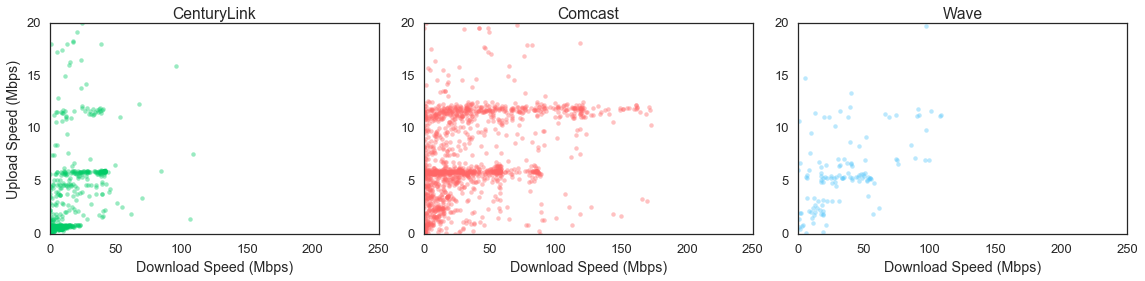

In [93]:
fig, axes = plt.subplots(1, 3, figsize=(16,4))

for i, (name, group) in enumerate(isp_groups_allcon):
    axes[i].scatter(group.actual_download, group.actual_upload, alpha=0.4, label=isp_names[i], color=isp_colours[i],\
                   linewidth=0)
    axes[i].set_xlim(0,250)
    axes[i].set_ylim(0,20)
    axes[i].set_title(isp_names[i])
    axes[i].set_xlabel('Download Speed (Mbps)')
    if i == 0:
        axes[i].set_ylabel('Upload Speed (Mbps)')

plt.tight_layout()
#plt.savefig('dl_vs_ul_isps.pdf')

Zooming in on the lower speeds, again we see these bands, most prominent for Comcast, but also existing for CenturyLink and possibly Wave. (Also present if we keep the connection type separation)

## Advertised Speeds



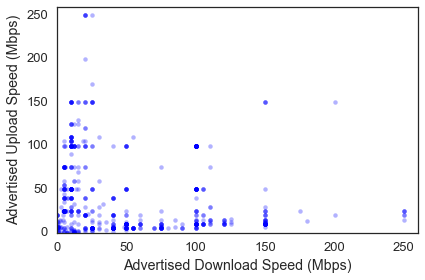

In [94]:
fig, ax = plt.subplots(1,1)

ax.scatter(df_isps.advertised_download, df_isps.advertised_upload, alpha=0.3, linewidth=0)
ax.set_ylim(0, 260)
ax.set_xlim(0, 260)
ax.set_xlabel('Advertised Download Speed (Mbps)')
ax.set_ylabel('Advertised Upload Speed (Mbps)')
plt.tight_layout()
plt.savefig('dlad_vs_ulad_allisps.pdf')

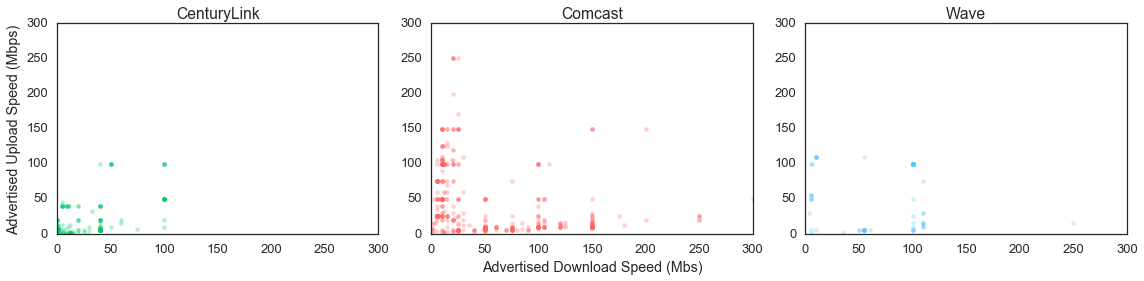

In [95]:
fig, axes = plt.subplots(1,3, figsize=(16,4))

count = 0
for i, group in isp_groups_allcon:
    axes[count].scatter(group.advertised_download, group.advertised_upload, alpha=0.3, label=i,\
                        color=isp_colours[count], linewidth=0)
    if count == 1:
        axes[count].set_xlabel("Advertised Download Speed (Mbs)")
    if count == 0:
        axes[count].set_ylabel("Advertised Upload Speed (Mbps)")
    axes[count].set_ylim(0,300)
    axes[count].set_xlim(0,300)
    axes[count].set_title(isp_names[count])
    
    count += 1
    
plt.tight_layout()
plt.savefig('dlad_vs_ulad.pdf')

Plotting the advertised upload speeds vs the advertised download speeds should yield a roughly straight line of low gradient as higher upload speeds tend to be offered with higher download speeds, but they are normally lower than the download speeds.

Several reasons could be noted for the patterns seen. Firstly, people could simply be mixing up the values when entering them into the boxes. Secondly, Comcast is cable and may just have higher upload speeds. Thirdly, upload speeds might be advertised in kbps, which users have not noticed.

### Correcting swapped advertised speeds

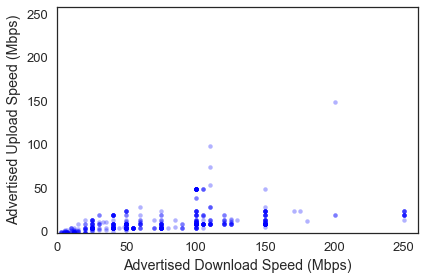

In [96]:
fig, ax = plt.subplots(1,1)

ax.scatter(df_isps.dl_ad_swap, df_isps.ul_ad_swap, alpha=0.3, linewidth=0)
ax.set_ylim(0, 260)
ax.set_xlim(0, 260)
ax.set_xlabel('Advertised Download Speed (Mbps)')
ax.set_ylabel('Advertised Upload Speed (Mbps)')
plt.tight_layout()
plt.savefig('dlad_vs_ulad_allisps_corrected.pdf')

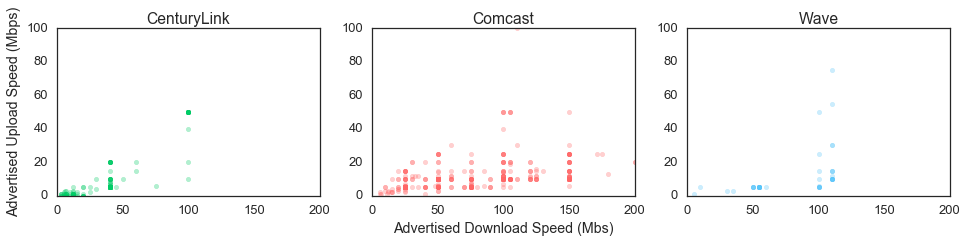

In [99]:
fig, axes = plt.subplots(1,3, figsize=(16,3))

count = 0
for i, group in isp_groups_allcon:
    axes[count].scatter(group.dl_ad_swap, group.ul_ad_swap, alpha=0.3, label=i, color=isp_colours[count])
    if count == 1:
        axes[count].set_xlabel("Advertised Download Speed (Mbs)")
    if count == 0:
        axes[count].set_ylabel("Advertised Upload Speed (Mbps)")
    axes[count].set_ylim(0,100)
    axes[count].set_xlim(0,200)
    axes[count].set_title(isp_names[count])
    
    count += 1
plt.show()

Swapping the download and upload advertised speeds seems to give plots that make much more sense. There is no longer a mirroring along the $y \approx x$ line and advertised upload speeds are consistently lower than the corresponding advertised download speed, which makes much more sense!

### Advertised Download Speeds

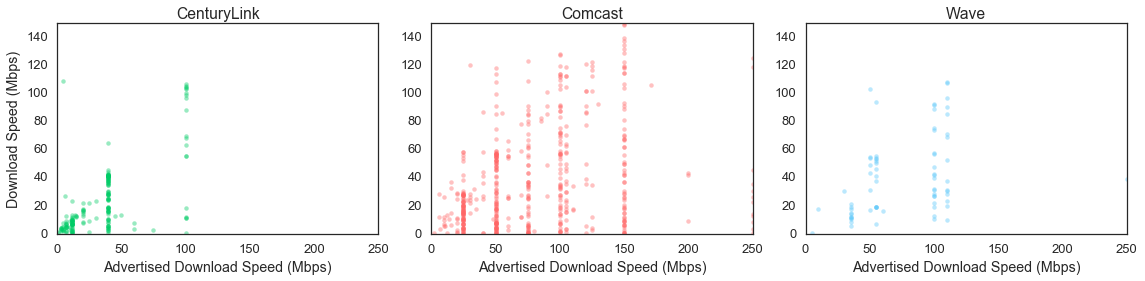

In [101]:
fig, axes = plt.subplots(1, 3, figsize=(16,4))

for i, (name, group) in enumerate(isp_groups_allcon):
    axes[i].scatter(group.dl_ad_swap, group.actual_download, alpha=0.4, label=isp_names[i], color=isp_colours[i],\
                   linewidth=0)
    axes[i].set_xlim(0,250)
    axes[i].set_ylim(0,150)
    axes[i].set_title(isp_names[i])
    axes[i].set_xlabel('Advertised Download Speed (Mbps)')
    if i == 0:
        axes[i].set_ylabel('Download Speed (Mbps)')

plt.tight_layout()
#plt.savefig('dlad_vs_dl_isps_corrected.pdf')

Plotting the actual download speed vs the advertised download speed allows us to see what speeds people are getting relative to what they are promised by their ISP. There is of course some error here as the advertised speeds are self reported.

Several things are noticeable. Firstly, for CenturyLink and Wave, there is a distinct separation between services advertised as 200 Mbps or less and the Gigabit services, advertised as 1000 Mbps. Comcast, does not have any responses that have advertised speeds higher than 250 Mbps. Do they not offer services higher than this?

The plots also show that no matter what service you go for, you could recieve a wide range of speeds.

There is a chance that some people reporting their advertised speed an order of magnitude out...

Zooming in on the lower speeds lets us see vertical columns of points probably corresponding to the advertised speeds of the services offered by the ISPs. We also see that even at low speeds, there can be a high level of variation in the speeds that are recieved vs the speeds that are offered.

**Plot vertical lines of the advertised speeds on currently offered products**

### Advertised Upload Speeds

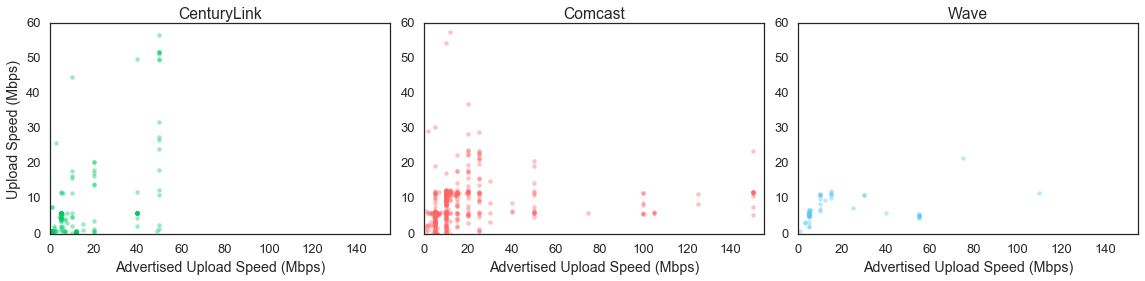

In [103]:
fig, axes = plt.subplots(1, 3, figsize=(16,4))

for i, (name, group) in enumerate(isp_groups_allcon):
    axes[i].scatter(group.ul_ad_swap, group.actual_upload, alpha=0.4, label=isp_names[i], color=isp_colours[i],\
                   linewidth=0)
    axes[i].set_xlim(0,155)
    axes[i].set_ylim(0,60)
    axes[i].set_title(isp_names[i])
    axes[i].set_xlabel('Advertised Upload Speed (Mbps)')
    if i == 0:
        axes[i].set_ylabel('Upload Speed (Mbps)')

plt.tight_layout()
#plt.savefig('dlad_vs_dl_isps_corrected.pdf')

#### Advertised Speeds Split By Connection Type

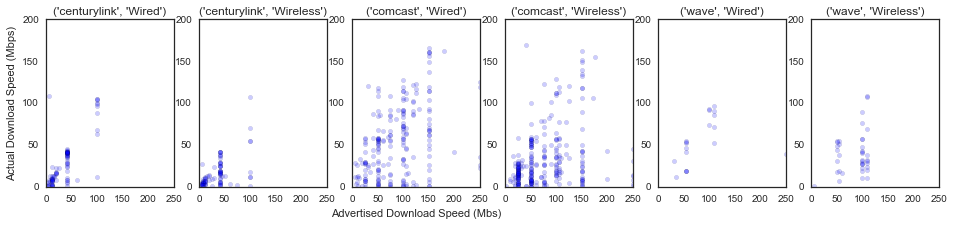

In [231]:
fig, axes = plt.subplots(1,6, figsize=(16,3))

count = 0
for i, group in isp_groups:
    axes[count].scatter(group.dl_ad_swap, group.actual_download, alpha=0.2, label=i)
    if count == 2:
        axes[count].set_xlabel("Advertised Download Speed (Mbs)")
    if count == 0:
        axes[count].set_ylabel("Actual Download Speed (Mbps)")
    axes[count].set_ylim(0,200)
    axes[count].set_xlim(0,250)
    axes[count].set_title(i)
    
    count += 1
plt.show()

A more realistic trend is now seen, with advertised download speeds showing a higher correlation with the actual download speeds.

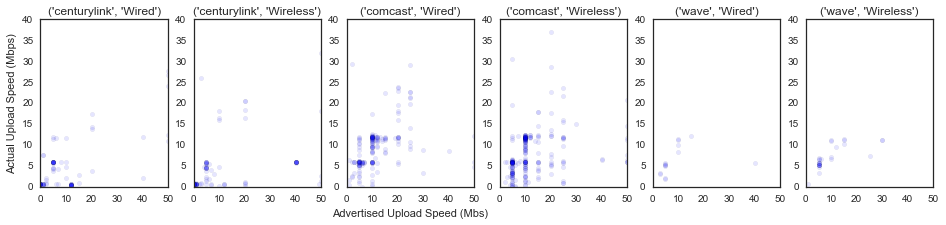

In [232]:
fig, axes = plt.subplots(1,6, figsize=(16,3))

count = 0
for i, group in isp_groups:
    axes[count].scatter(group.ul_ad_swap, group.actual_upload, alpha=0.1, label=i)
    if count == 2:
        axes[count].set_xlabel("Advertised Upload Speed (Mbs)")
    if count == 0:
        axes[count].set_ylabel("Actual Upload Speed (Mbps)")
    axes[count].set_ylim(0,40)
    axes[count].set_xlim(0,50)
    axes[count].set_title(i)
    
    count += 1
plt.show()

The equivalent plots for upload speed are still slightly messy, with all upload speeds appearing to be concentrated at low speeds. There appears to be a slight positive trend.

### DL Speed vs Advertised DL Speed Heatmap

In [113]:
df_reg = df[(df.advertised_download < 250) & (not np.isnan(df['advertised_download'].any()))].copy()                                   

In [114]:
dl_cutter = xrange(0, 175, 25)
df_reg['dl_cut'] = pd.cut(df_reg['advertised_download'], dl_cutter)

In [115]:
dl_ratio_cutter = np.arange(0, 125, 25)
df_reg['dl_ratio_cut'] = pd.cut(df_reg['dl_ratio_swap'], dl_ratio_cutter)

In [116]:
table = pd.pivot_table(df_reg, values='actual_download', index='dl_ratio_cut', columns=['dl_cut'], aggfunc='count')

In [117]:
table_norm = table / table.sum() * 100
table_norm.sort_index(ascending=False)

dl_cut,"(0, 25]","(25, 50]","(50, 75]","(75, 100]","(100, 125]","(125, 150]"
dl_ratio_cut,,,,,,
"(75, 100]",24.834437,25.78125,15.094340,16.176471,21.052632,19.230769
"(50, 75]",24.834437,20.31250,7.547170,26.470588,15.789474,5.769231
"(25, 50]",22.516556,22.65625,37.735849,29.411765,28.947368,25.000000
"(0, 25]",27.814570,31.25000,39.622642,27.941176,34.210526,50.000000


In [118]:
#yticks = ['0 - 20', '20 - 40', '40- 60', '60 - 80', '80 - 100']
dl_yticks = ['0 - 25', '25 - 50', '50 - 75', '75 - 100']
#yticks = ['0 - 10', '10 - 20', '20 - 30', '30 - 40', '40 - 50', '50 - 60', '60 - 70', '70 - 80', '80 - 90', '90 - 100' ]
dl_xticks = ['0 - 25', '25 - 50', '50 - 75', '75 - 100', '100 - 125', '125 - 150', '150 - 175', '175 - 200']

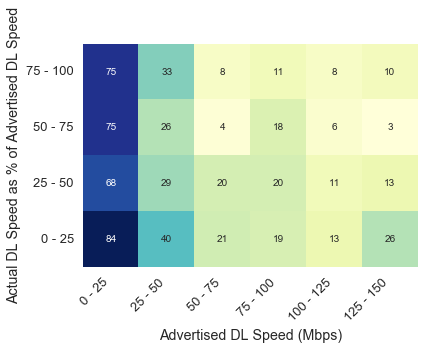

In [119]:
ax_table = sns.heatmap(table, annot=True, cbar=False, yticklabels=dl_yticks, xticklabels=dl_xticks, cmap='YlGnBu')
ax_table.invert_yaxis()
plt.yticks(rotation=0)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Advertised DL Speed (Mbps)')
plt.ylabel('Actual DL Speed as % of Advertised DL Speed')

The heatmap shows the number of records obtaining a binned percentage of the advertised download speed.

The results are hampered by there being no unique identifier for each person recording.

Same heatmap as above but normalised.

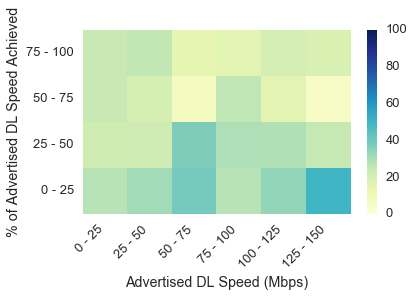

In [120]:
ax_table_norm = sns.heatmap(table_norm, vmin=0, vmax=100, yticklabels=dl_yticks, xticklabels=dl_xticks, annot=False, cmap='YlGnBu')
ax_table_norm.invert_yaxis()
plt.yticks(rotation=0)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Advertised DL Speed (Mbps)')
plt.ylabel('% of Advertised DL Speed Achieved')
plt.tight_layout()

The distribution of relative DL speeds is fairly even at low speed packages. At advertised speeds above 50 Mbps, there appears to be a slight skewing towards lower speeds, though there is a fairly consistent band of records acheiving over 75 %.

### Distribution of % Download for Each ISP

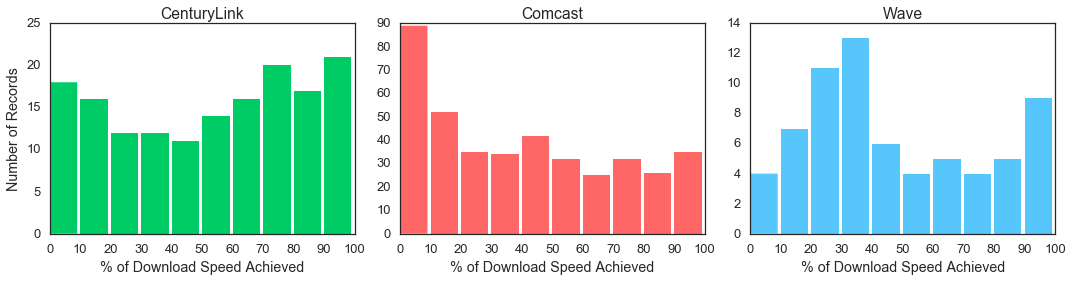

In [121]:
fig, axes = plt.subplots(1,3,figsize=(15,4))

bins = np.arange(0,110, 10)
count = 0
for i, group in enumerate(isp_groups_allcon):
    isp, group = group
    axes[count].hist(group['dl_ratio_swap'], bins=bins, linewidth=0, width=9, range=[0,100], color=isp_colours[count])
    axes[count].set_title(isp_names[count])
    axes[count].set_xticks(bins)
    if count == 0:
        axes[count].set_ylabel('Number of Records')
    axes[count].set_xlabel('% of Download Speed Achieved')
    count += 1

plt.tight_layout()
plt.savefig('dlratio_hist_isps.pdf')

Splitting the DL ratios by ISP, we can see that CenturyLink users experience a fairly uniform distribution, whilst Comcast yields a slightly exponenetial distribution and Wave has an apparently bimodal distribution.

### UL Speed vs Advertised UL Speed Heatmap


In [122]:
ul_cutter = xrange(0, 35, 5)
df_reg['ul_cut'] = pd.cut(df_reg['advertised_upload'], ul_cutter)

In [123]:
ul_ratio_cutter = np.arange(0, 125, 25)
df_reg['ul_ratio_cut'] = pd.cut(df_reg['ul_ratio_swap'], ul_ratio_cutter)

In [124]:
ul_xticks = ['0 - 5', '5 - 10', '10 - 15', '15 - 20', '20 - 25', '25 - 30', '30 - 35']
ul_yticks = list(dl_yticks)

In [125]:
table_ul_vs_ulad = pd.pivot_table(df_reg, values='actual_upload', index='ul_ratio_cut', columns=['ul_cut'], aggfunc='count')

In [126]:
table_ul_norm = table_ul_vs_ulad / table_ul_vs_ulad.sum() * 100
table_ul_norm.sort_index(ascending=False)

ul_cut,"(0, 5]","(5, 10]","(10, 15]","(15, 20]","(20, 25]","(25, 30]"
ul_ratio_cut,,,,,,
"(75, 100]",33.962264,27.536232,50.000000,21.052632,22.448980,20.0
"(50, 75]",32.075472,37.681159,26.470588,42.105263,36.734694,20.0
"(25, 50]",20.754717,21.739130,8.823529,15.789474,24.489796,60.0
"(0, 25]",13.207547,13.043478,14.705882,21.052632,16.326531,NaN


(array([ 0.5,  1.5,  2.5,  3.5]), <a list of 4 Text yticklabel objects>)

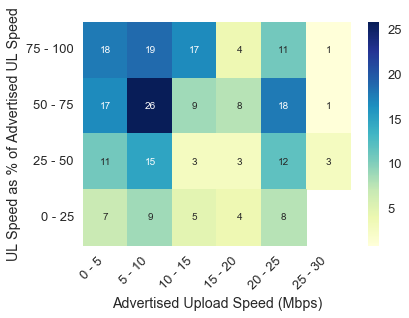

In [127]:
ax_count_ul = sns.heatmap(table_ul_vs_ulad, cmap='YlGnBu', annot=True, xticklabels=ul_xticks, yticklabels=ul_yticks)
ax_count_ul.invert_yaxis()
plt.xlabel('Advertised Upload Speed (Mbps)')
plt.ylabel('UL Speed as % of Advertised UL Speed')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

(array([ 0.5,  1.5,  2.5,  3.5]), <a list of 4 Text yticklabel objects>)

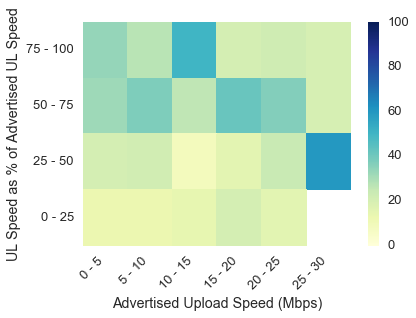

In [128]:
ax_count_ul_norm = sns.heatmap(table_ul_norm, cmap='YlGnBu', vmin=0, vmax=100, xticklabels=ul_xticks, yticklabels=ul_yticks)
ax_count_ul_norm.invert_yaxis()
plt.xlabel('Advertised Upload Speed (Mbps)')
plt.ylabel('UL Speed as % of Advertised UL Speed')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

For upload speeds, there appears to be a more significant number of people obtaining speeds closer to those advertised.

## Costs (of non Gigabit services)

In [129]:
df_cost = df_isps[(df_isps.cost_of_service != 'dont_know') & (df_isps.advertised_download < 250)].copy()

In [130]:
costs = df_cost.cost_of_service
costs = costs.str.replace('_', ' ')

cost_int = []
for cost in costs:
    nums = [int(s) for s in cost.split() if s.isdigit()]
    if (len(nums) == 1) & (nums[0] == 25):
        nums[0] = 0
    elif (len(nums) == 1) & (nums[0] == 100):
        nums[0] = 100
    
    nums = nums[0]
    cost_int.append(nums)

df_cost['cost_int'] = cost_int

In [131]:
cost_groups = df_cost.groupby([df_cost.isp_user, df_cost.cost_int])

In [132]:
isps = []
costs = []
user_counts = []
mean_speeds = []
median_speeds = []
dl_speeds = []

for i, group in cost_groups:
    isp, cost = i
    isps.append(isp)
    costs.append(cost)
    user_counts.append(group.actual_download.count())
    mean_speeds.append(group.actual_download.mean())
    median_speeds.append(group.actual_download.median())
    dl_speeds.append(group.actual_download)

isps = list(set(isps))
costs = list(set(costs))
user_counts = [user_counts[i:i+5] for i in range(0, len(user_counts), 5)]
mean_speeds = [mean_speeds[i:i+5] for i in range(0, len(mean_speeds), 5)]
median_speeds = [median_speeds[i:i+5] for i in range(0, len(median_speeds), 5)]
dl_speeds = [dl_speeds[i:i+5] for i in range(0, len(dl_speeds), 5)]  

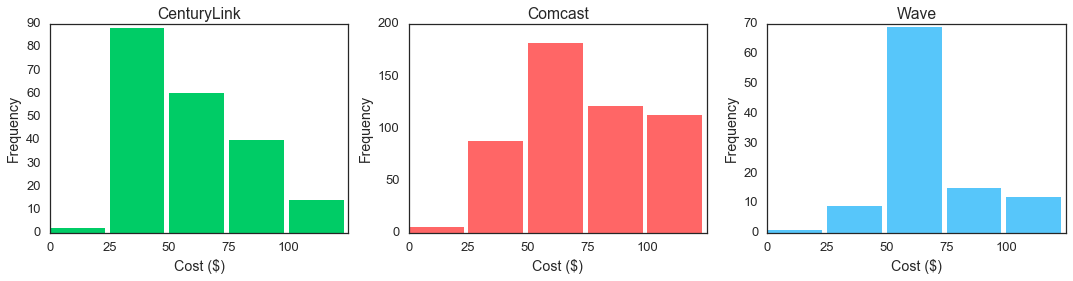

In [133]:
fig, axes = plt.subplots(1,3, figsize=(15,4))

isp_names = ['CenturyLink','Comcast','Wave']

for i, isp in enumerate(isps):
    
    axes[i].bar(costs, user_counts[i], label=isp, width=23, linewidth=0, color=isp_colours[i])
    axes[i].set_xlim(0,125)
    axes[i].xaxis.set_ticks([0,25,50,75,100])
    axes[i].set_title(isp_names[i])
    axes[i].set_ylabel('Frequency')
    axes[i].set_xlabel('Cost ($)')
    
plt.tight_layout()
plt.savefig('cost_hist_isps.pdf')

The distribution of costs for broad band show quite different distribtuions for each of the main ISPs. Centurylink has little. Comcast seems to have very few subscribers under \$25 with a distribution skewed towards the lower-middle prices afer that. Comcast and Wave both have skewed distributions centered on the \$50 to \$75 segements, with Comcast seeming to have a relatively higher uptake of higher value products (although the Wave sample is small). It is important to note that the values above \$100 represent all prices above \$100, not just between \$100 and \$125. Comcast offers TV etc. too so perhaps this is the reason for the higher cost distribution.

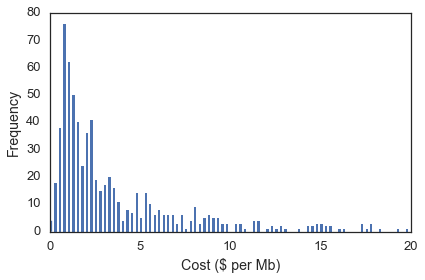

In [621]:
ax_costpermb = df_cost['dollar_per_dl'].hist(bins=80, range=[0,20], grid=False, width=0.13, linewidth=0)
ax_costpermb.set_ylabel('Frequency')
ax_costpermb.set_xlabel('Cost ($ per Mb)')
plt.tight_layout()
plt.savefig('cost_per_mb_hist.pdf')

The cost in \$ per Mb across all ISPs peaks between \$1 and \$1.25, but with a skewed distribution such that there are a significant number of records paying over $5 per Mb.

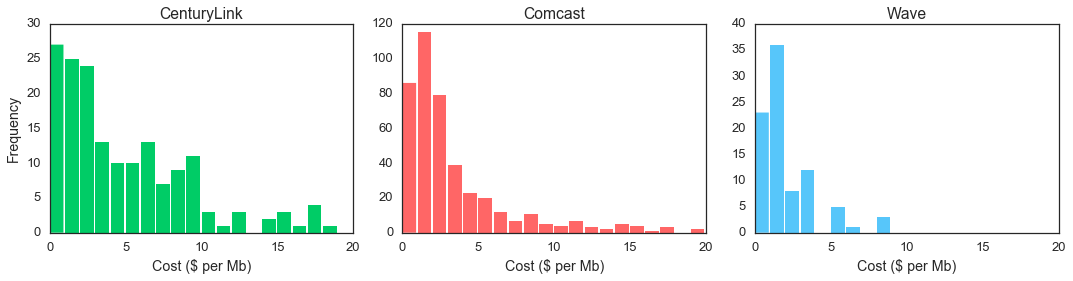

In [623]:
cost_groups_reg = df_cost.groupby('isp_user')

fig, axes = plt.subplots(1,3,figsize=(15,4))

bins = np.arange(0, 21, 1)

count = 0
for i, group in enumerate(cost_groups_reg):
    isp, group = group
    axes[count].hist(group['dollar_per_dl'], bins=bins, linewidth=0, width=0.9, range=[0,20], color=isp_colours[count])
    axes[count].set_title(isp_names[count])
    if count == 0:
        axes[count].set_ylabel('Frequency')
    axes[count].set_xlabel('Cost ($ per Mb)')
    count += 1
plt.tight_layout()
plt.savefig('cost_per_mb_hist_isps.pdf')

Each of the individual ISPs also display a similar distribution, though the bin sizes are larger. CenturyLink users appear to get a slightly better deal, but all the peaks hover around the \$1 to \$2 region.

### Does Speed Scale with Cost?

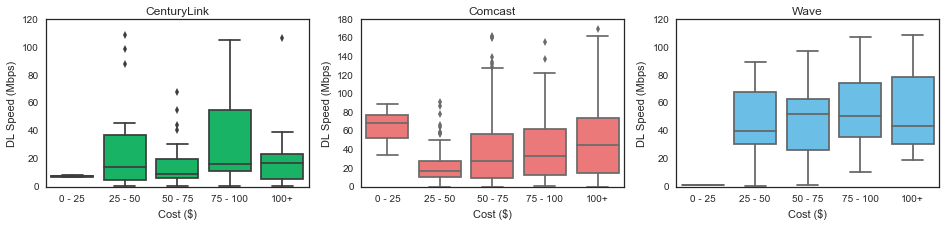

In [383]:
fig, axes = plt.subplots(1,3,figsize=(16,3))

cost_labels = ['0 - 25', '25 - 50', '50 - 75', '75 - 100', '100+']

for i, group in enumerate(cost_groups_reg):
    isp, group = group
    axes[i] = sns.boxplot(x='cost_int', y='actual_download', data=group, ax=axes[i], color=isp_colours[i])
    axes[i].set_title(isp_names[i])
    axes[i].set_xlabel('Cost ($)')
    axes[i].set_ylabel('DL Speed (Mbps)')
    axes[i].set_xticklabels(cost_labels)


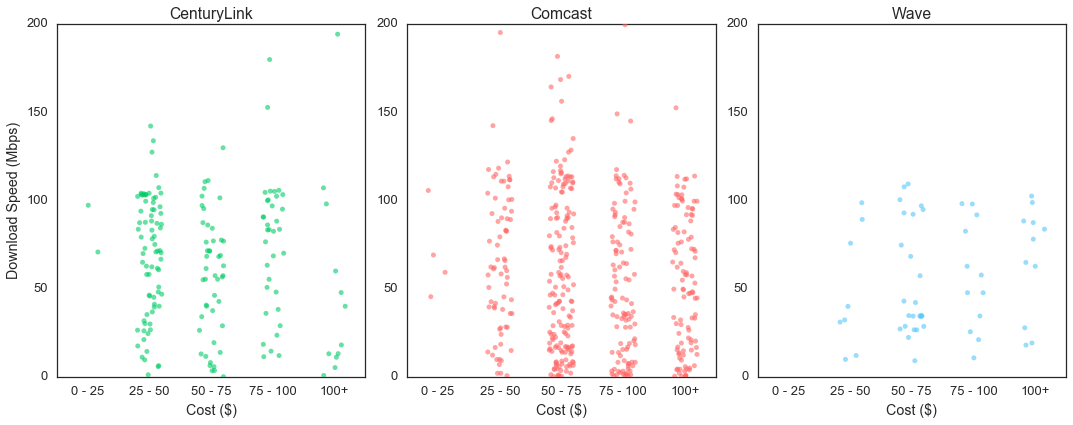

In [808]:
fig, axes = plt.subplots(1,3,figsize=(15,6))

cost_labels = ['0 - 25', '25 - 50', '50 - 75', '75 - 100', '100+']

for i, group in enumerate(cost_groups_reg):
    isp, group = group
    axes[i] = sns.stripplot(x='cost_int', y='dl_ratio_swap', data=group, ax=axes[i], color=isp_colours[i], jitter=0.2, alpha=0.6, linewidth=0)
    axes[i].set_title(isp_names[i])
    axes[i].set_xlabel('Cost ($)')
    if i == 0:
        axes[i].set_ylabel('Download Speed (Mbps)')
    else:
        axes[i].set_ylabel('')
    axes[i].set_xticklabels(cost_labels)
    axes[i].set_ylim(0,200)

plt.tight_layout()
plt.savefig('cost_vs_dl_strip.pdf')

On first appearances it would seem that there is little relation between how much people are paying for their broadband to the speeds they are recieving. Unravelling any relationship is hampered by the lack of data certain groups. There may be user error when reporting the cost and hardware related factors affecting the speed. People may also be reporting the cost of a package of services that includes broadband.

## Gigabit Speeds

In [149]:
df_gig = df_isps[df_isps['advertised_download'] > 250]

gig_groups = df_gig.groupby('isp_user')
for i, group in gig_groups:
    print i
    print "Number of records:", len(group)
    print "Mean DL: ", group.actual_download.mean()
    print "Median DL: ", group.actual_download.median()
    print "Std DL: ", group.actual_download.std()
    print "Mean UL: ", group.actual_upload.mean()
    print "Median UL: ", group.actual_upload.median()
    print "Std UL: ", group.actual_upload.std()
    print '--------------'

centurylink
Number of records: 59
Mean DL:  169.948813559
Median DL:  72.2
Std DL:  203.489605471
Mean UL:  165.770847458
Median UL:  72.83
Std UL:  189.182457817
--------------
comcast
Number of records: 2
Mean DL:  182.535
Median DL:  182.535
Std DL:  105.054854481
Mean UL:  261.13
Median UL:  261.13
Std UL:  352.704862456
--------------
wave
Number of records: 26
Mean DL:  157.768461538
Median DL:  99.92
Std DL:  156.216390809
Mean UL:  259.905769231
Median UL:  87.9
Std UL:  282.976501302
--------------


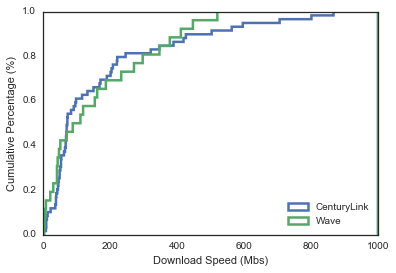

In [168]:
axes = plt.subplot(111)
quintiles = ['0', '20', '40', '60', '80', '100']

count=0
for i, group in gig_groups:
    if i == 'comcast':
        count += 1
        continue
    hist = group['actual_download'].hist(bins=bins_cum, grid=False, cumulative=True, histtype='step',\
                                         normed=True, label=isp_names[count], linewidth=2.5)
    count += 1

plt.legend(loc='lower right')
axes.set_xlabel("Download Speed (Mbs)")
axes.set_ylabel("Cumulative Percentage (%)")
axes.set_xlim(0,1000)
axes.set_ylim(0,1)
plt.show()

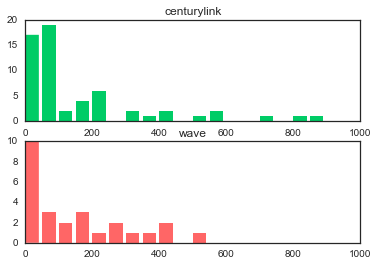

In [388]:
fig, axes = plt.subplots(2,1)

bins = np.arange(0,1000, 50)
count = 0
for i, group in enumerate(gig_groups):
    isp, group = group
    if isp == 'comcast':
        continue
    axes[count].hist(group['actual_download'], bins=bins, linewidth=0, width=40, color=isp_colours[count])
    axes[count].set_title(isp)
    count += 1

In [152]:
costs = df_gig.cost_of_service
costs = costs.str.replace('_', ' ')

cost_int = []
for cost in costs:
    nums = [int(s) for s in cost.split() if s.isdigit()]
    if (len(nums) == 1) & (nums[0] == 25):
        nums[0] = 0
    elif (len(nums) == 1) & (nums[0] == 100):
        nums[0] = 100
    
    nums = nums[0]
    cost_int.append(nums)

df_gig['cost_int'] = cost_int

/Users/George/miniconda3/envs/py2kanaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [153]:
df_gig_hicost = df_gig[df_gig.cost_int >= 75]

In [154]:
gig_hicost_groups = df_gig_hicost.groupby('isp_user')

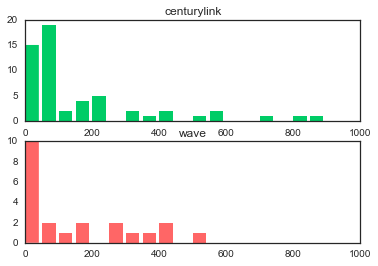

In [389]:
fig, axes = plt.subplots(2,1)

bins = np.arange(0,1000, 50)
count = 0
for i, group in enumerate(gig_hicost_groups):
    isp, group = group
    if isp == 'comcast':
        continue
    axes[count].hist(group['actual_download'], bins=bins, linewidth=0, width=40, color=isp_colours[count])
    axes[count].set_title(isp)
    count += 1

There appears to be no difference when taking into account only high cost services.

# Time

## Hour of the day

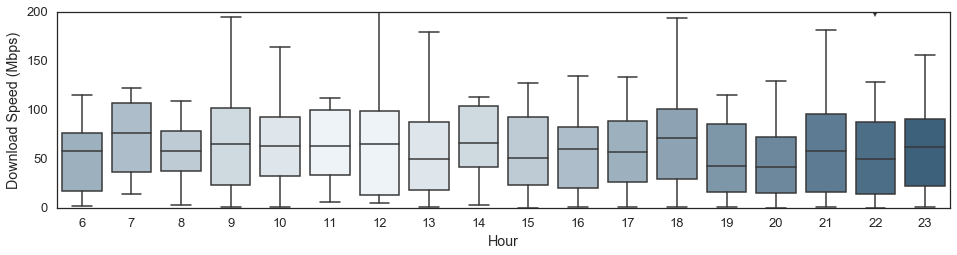

In [651]:
fig, ax = plt.subplots(1,1,figsize=(16,3.5))
daynight_pal = sns.diverging_palette(240, 240, n=24, l=40, center='light')
#sns.stripplot(y='actual_download', x='hour', data=df_isps, jitter=True, size=2, palette='Blues_d')
sns.boxplot(y='dl_ratio_swap', x='hour', data=df_isps, palette=daynight_pal, linewidth=1.5)
#sns.diverging_palette(15,250, n=24)
ax.set_ylim(0,200)
ax.set_xlim(5.5,23.5)
ax.set_ylabel('Download Speed (Mbps)')
ax.set_xlabel('Hour')

There is no obvious trend by hour. The sample sizes are too small for certain hours and the variation in the samples is too large to observe any statistically significant differences.

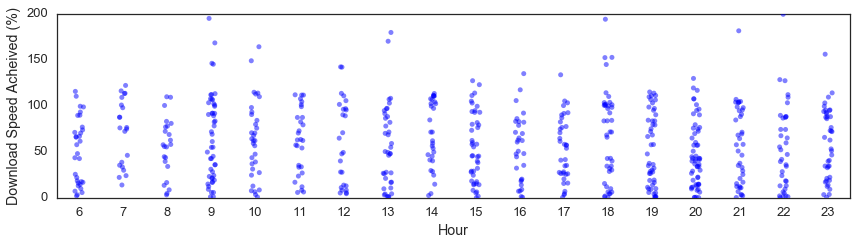

In [700]:
fig, ax = plt.subplots(1,1,figsize=(12,3.5))
#daynight_pal = sns.diverging_palette(240, 240, n=24, l=40, center='light')
#daynight_pal = sns.color_palette("coolwarm", 24)
#sns.stripplot(y='actual_download', x='hour', data=df_isps, jitter=True, size=2, palette='Blues_d')
sns.stripplot(y='dl_ratio_swap', x='hour', data=df_isps, linewidth=0, jitter=0.1, color='Blue', alpha=0.5)
#sns.diverging_palette(15,250, n=24)
ax.set_ylim(0,200)
ax.set_xlim(5.5,23.5)
ax.set_ylabel('Download Speed Acheived (%)')
ax.set_xlabel('Hour')
plt.tight_layout()
plt.savefig('hour_dlratio_strip.pdf')

## Day of the Week

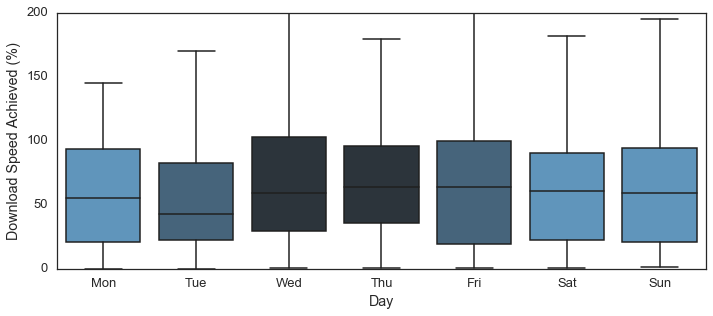

In [702]:
fig, ax = plt.subplots(1,1,figsize=(10,4.5))
dotw=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
dread=sns.diverging_palette(240, 240, l=60, n=6, center='dark')
sns.boxplot(y='dl_ratio_swap', x='day_num', data=df_isps[df_isps.actual_download < 250], palette=dread, linewidth=1.5)
ax.set_ylim(0,200)
ax.set(xticklabels=dotw)
ax.set_xlabel('Day')
ax.set_ylabel('Download Speed Achieved (%)')

plt.tight_layout()
plt.savefig('day_vs_dlratio_box.pdf')

[[<matplotlib.text.Text at 0x123629850>,

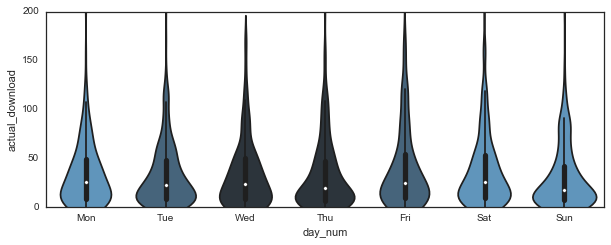

In [117]:
fig, ax = plt.subplots(1,1,figsize=(10,3.5))
dotw=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
sns.violinplot(y='actual_download', x='day_num', data=df_isps[df_isps.actual_download < 250], palette=dread)
ax.set_ylim(0,200)
ax.set(xticklabels=dotw)

Again we see no trend in the download speed with respect to the days of the week, which I found slightly surprising. In this case, colour palette represents existential dread. The middle of the week is clearly visible, with things lightening up again as the weekend rolls in. The one thing I would go so far as to say here is that it's good that there doesn't seem to be a deterioration of speeds at peak times.

In [102]:
df_day_hour = df_isps[df_isps['actual_download'] < 250]
day_hour_std = df_day_hour[(df_day_hour['hour'] >= 6)]
df_day_hour = df_day_hour.groupby(['day', 'hour'], as_index=False)

In [103]:
day_hour_means = df_day_hour.aggregate(np.mean)

In [119]:
day_hour_means = df_day_hour.aggregate(np.mean)
day_hour_means = day_hour_means[['day_num','hour','actual_download']]
day_hour_means = day_hour_means[(day_hour_means['hour'] >= 6)]
day_hour_means = day_hour_means.pivot("hour","day_num","actual_download")

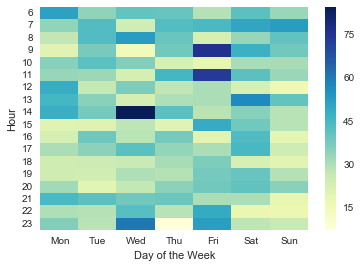

In [121]:
sns.heatmap(day_hour_means, cmap='YlGnBu', xticklabels=dotw)
plt.yticks(rotation=0)
plt.ylabel("Hour")
plt.xlabel("Day of the Week")

There appears to be no trend of the mean speed across different hours at different times of the week.

In [122]:
day_hour_med = df_day_hour.aggregate(np.median)
day_hour_med = day_hour_med[['day_num','hour','actual_download']]
day_hour_med = day_hour_med[(day_hour_med['hour'] >= 6)]
day_hour_med = day_hour_med.pivot("hour","day_num","actual_download")

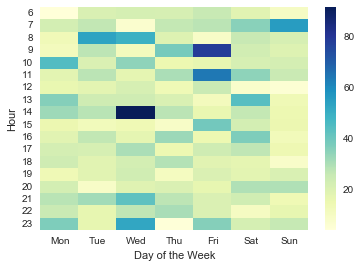

In [123]:
sns.heatmap(day_hour_med, cmap='YlGnBu', xticklabels=dotw)
plt.yticks(rotation=0)
plt.ylabel("Hour")
plt.xlabel("Day of the Week")

This is confirmed across the median. Although there is a slightly lighter patch on Sunday afternoons. Is this peak internet usage time?

In [147]:
day_hour_count_table = pd.pivot_table(df_isps[df_isps.hour > 5], index='hour',\
                                      columns='day_num', values='actual_download', aggfunc='count')

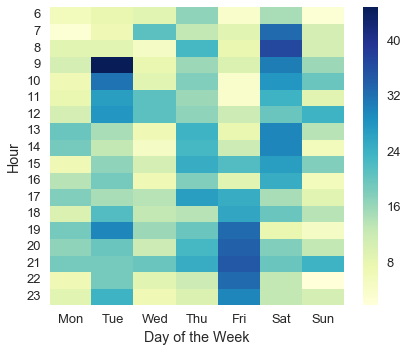

In [699]:
fig, ax = plt.subplots(1,1,figsize=(6,5))
ax = sns.heatmap(day_hour_count_table, cmap='YlGnBu')
plt.yticks(rotation=0)
ax.set_xticklabels(dotw)
plt.ylabel("Hour")
plt.xlabel("Day of the Week")
plt.tight_layout()
plt.savefig('count_day_hour_hmap.pdf')

There are consistently few speed tests between midnight and 6am. Seems to hover around 20 for most of the week, apart from Tuesday mornings, Friday nights, and Saturday mornings. Make of that what you will.

On a serious note, it does highlight that some values are based on small numbers of samples.

In [127]:
day_hour_std = df_day_hour[['day','hour','actual_download']]
day_hour_std = day_hour_std.aggregate(np.std, ddof=0)
day_hour_std = day_hour_std[(day_hour_std['hour'] >= 6)]
day_hour_std = day_hour_std.pivot("hour","day","actual_download")

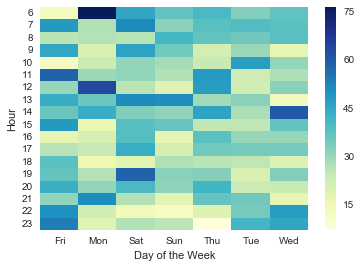

In [129]:
sns.heatmap(day_hour_std, cmap='YlGnBu')
plt.yticks(rotation=0)
plt.ylabel("Hour")
plt.xlabel("Day of the Week")

The variation itself is widely varying across the times of the week.

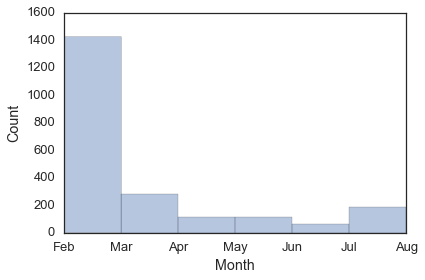

In [754]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax = sns.distplot(df_isps['month_num'], bins=6, kde=False)
#ax = df_isps['month'].plot(type='bar')
ax.set_xticklabels(['Feb','Mar','Apr','May','Jun','Jul','Aug'])
ax.set_xlim(2,8)
ax.set_xlabel('Month')
ax.set_ylabel('Count')
plt.tight_layout()
plt.savefig('month_hist.pdf')

# Geography